# Preface
Introduces the project's objectives, dataset source, and a brief overview of the dataset, including its source, structure, and initial inspection.

---

## Objective

The goal of this project is to build a predictive model for medical insurance charges using the Medical Cost Personal Dataset from Kaggle. The dataset was provided by Mirichoi0218 and contains demographic and lifestyle features along with annual insurance charges. The analysis involves data preprocessing (handling missing values, duplicates, outliers), exploratory data analysis, hypothesis testing, and linear regression modeling to identify key drivers of insurance costs.

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [559]:
import warnings
warnings.filterwarnings('ignore')

The dataset was downloaded from [Medical Cost Personal Dataset (Kaggle)](https://www.kaggle.com/datasets/mirichoi0218/insurance/data)

In [560]:
# Load dataset
df = pd.read_csv(r'Datasets/insurance_original.csv')

## Overview

This dataset consists of 7 columns capturing individual medical insurance data:
- **age**: Age of primary beneficiary (years)
- **sex**: Gender (`male` or `female`)
- **bmi**: Body Mass Index (kg/m²)
- **children**: Number of dependents covered by insurance
- **smoker**: Smoking status (`yes` or `no`)
- **region**: Residential area in the US (`northeast`, `northwest`, `southeast`, `southwest`)
- **charges**: Annual medical insurance charges billed (USD)

In [561]:
# Preview dataset head
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,NaN,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,NaN,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


In [562]:
# preview dataset tail
df.tail()

,age,sex,bmi,children,smoker,region,charges
1360,19.0,male,30.400,0.0,no,southwest,1256.29900
1361,22.0,female,39.805,0.0,no,northeast,2755.02095
1362,NaN,female,28.120,3.0,no,northwest,11085.58680
1363,54.0,female,32.680,0.0,no,northeast,10923.93320
1364,60.0,female,35.100,0.0,no,southwest,12644.58900


In [563]:
# Dataset info and description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1297 non-null   float64
 1   sex       1322 non-null   object 
 2   bmi       1299 non-null   float64
 3   children  1298 non-null   float64
 4   smoker    1323 non-null   object 
 5   region    1325 non-null   object 
 6   charges   1299 non-null   float64
dtypes: float64(4), object(3)
memory usage: 74.8+ KB


We define a function `dataset_summary` below to summarize all key aspects of the dataset, including its structure, distributions, missing values, and outliers.

In [564]:
def dataset_summary(df, name="Dataset"):
    print(f"\n{'='*60}")  # Updated separator
    print(f"Summary of {name}")
    print(f"{'-'*50}\n")

    # Shape
    print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns\n")

    # Data types and info
    print("Column Data Types:")
    print(df.dtypes.value_counts())
    print("\nDetailed Info:")
    df.info()
    print("\n" + "-"*50)

    # Separate numerical and categorical
    numerical_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    print(f"\nNumerical Columns ({len(numerical_cols)}): {list(numerical_cols)}")
    print(f"Categorical Columns ({len(categorical_cols)}): {list(categorical_cols)}")
    print("\n" + "-"*50)

    # Missing values
    print("\nMissing Values:")
    missing_val = df.isnull().sum()
    missing_val = missing_val[missing_val > 0].sort_values(ascending=False)
    print(missing_val if not missing_val.empty else "No missing values.")
    print("\n" + "-"*50)

    # Unique values
    print("\nValue Counts per Column:")  # renamed section
    print(df.nunique().sort_values(ascending=False))
    print("\n" + "-"*50)

    # Duplicate rows
    dup = df.duplicated().sum()
    print(f"\nDuplicate Rows: {dup}")
    print("\n" + "-"*50)

    # Descriptive statistics
    print("\nDescriptive Statistics (Numerical):")
    print(df.describe().T)
    print("\n" + "-"*50)

    # Skewness and Kurtosis
    from scipy.stats import skew, kurtosis
    skewness = df[numerical_cols].skew()
    kurt = df[numerical_cols].kurtosis()
    skew_kurt = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurt})
    print("\nSkewness and Kurtosis:")
    print(skew_kurt)
    print("\n" + "-"*50)

    # Most frequent categorical values
    print("\nTop 5 Most Frequent Values in Categorical Columns:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts(dropna=False).head())
    print("\n" + "-"*50)

    # Outlier detection via IQR
    print("\nOutliers Detected (IQR Method):")
    outlier_counts = {}
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        outlier_counts[col] = df[(df[col] < lower) | (df[col] > upper)][col].count()
    outlier_df = pd.Series(outlier_counts)
    print(outlier_df[outlier_df > 0] if any(outlier_df > 0) else "No outliers detected.")
    print(f"\n{'='*50}\n")

In [565]:
# Call the summary function
dataset_summary(df, name='Insurance Dataset')


Summary of Insurance Dataset
--------------------------------------------------

Shape: 1365 rows x 7 columns

Column Data Types:
float64    4
object     3
Name: count, dtype: int64

Detailed Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1297 non-null   float64
 1   sex       1322 non-null   object 
 2   bmi       1299 non-null   float64
 3   children  1298 non-null   float64
 4   smoker    1323 non-null   object 
 5   region    1325 non-null   object 
 6   charges   1299 non-null   float64
dtypes: float64(4), object(3)
memory usage: 74.8+ KB

--------------------------------------------------

Numerical Columns (4): ['age', 'bmi', 'children', 'charges']
Categorical Columns (3): ['sex', 'smoker', 'region']

--------------------------------------------------

Missing Values:
age         68
children    67
bmi         66
charges   

# Part A: Data Preprocessing & EDA
Covers data preprocessing and exploratory data analysis to prepare and comprehend the dataset.

---

## 1. Data Preprocessing
Details the procedures for cleaning data: handling missing values, duplicates, outliers, and scaling

### Handling Missing Values
We impute missing data as follows:
1. **Numeric** (`age`, `bmi`, `children`, `charges`): fill NAs with median.
2. **Categorical** (`sex`, `smoker`, `region`): fill NAs with mode.
3. Verify no missing values remain.

In [566]:
def handle_missing(df):
    df = df.copy()
    for col in ['age','bmi','children','charges']:
        df[col].fillna(df[col].median(), inplace=True)
    for col in ['sex','smoker','region']:
        df[col].fillna(df[col].mode()[0], inplace=True)
    print('Remaining missing values:', df.isnull().sum().sum())
    return df

df_clean = handle_missing(df)

Remaining missing values: 0


### Duplicate Removal
Remove duplicate records to prevent bias.

In [567]:
print('Duplicates before:', df_clean.duplicated().sum())
df_clean = df_clean.drop_duplicates()
print('Duplicates after:', df_clean.duplicated().sum())

Duplicates before: 28
Duplicates after: 0


### Outlier Detection & Handling
Cap outliers in numeric columns using IQR clipping.

In [568]:
def cap_outliers(df):
    df = df.copy()
    for col in ['age','bmi','children','charges']:
        q1, q3 = df[col].quantile([0.25,0.75])
        iqr = q3 - q1
        df[col] = df[col].clip(lower=q1-1.5*iqr, upper=q3+1.5*iqr)
    print('Outliers capped.')
    return df

df_clean = cap_outliers(df_clean)

Outliers capped.


### Feature Scaling
Standardize numeric features to zero mean and unit variance.

In [569]:
scaler = StandardScaler()
num_cols = ['age','bmi','children']
df_scaled = df_clean.copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])
df_scaled.head()

,age,sex,bmi,children,smoker,region,charges
0,-1.455921,female,-0.466366,-0.929658,yes,southwest,16884.92400
1,-1.527530,male,0.522137,-0.094901,no,southeast,1725.55230
2,-0.811433,male,0.392470,1.574612,no,southeast,4449.46200
3,-0.453385,male,-1.341201,-0.929658,no,northwest,21984.47061
4,-0.524995,male,-0.301335,-0.929658,no,northwest,3866.85520


### Feature Encoding  
Convert all categorical variables into numeric indicators to prepare for modeling

The following operations ensure that every column is numeric and ready for further analysis:

1. **Binary Mapping** for two-level features (`sex`, `smoker`):  
   - `sex`: female -> 0, male -> 1  
   - `smoker`: no -> 0, yes -> 1  

2. **One-Hot Encoding** for multi-level features (`region`):  
   - Creates dummy columns for each region (dropping one to avoid collinearity)  

In [570]:
# Feature Encoding
df_encode = df_scaled.copy()
# df_encode = df_clean.copy()

# 1. Binary encode 'sex' and 'smoker'
df_encode['sex'] = df_encode['sex'].map({'female': 0, 'male': 1})
df_encode['smoker'] = df_encode['smoker'].map({'no': 0, 'yes': 1})

# 2. One-hot encode 'region'
df_encode = pd.get_dummies(df_encode, columns=['region'], drop_first=True)

# Show the transformed DataFrame
df_encode.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,-1.455921,0,-0.466366,-0.929658,1,16884.92400,False,False,True
1,-1.527530,1,0.522137,-0.094901,0,1725.55230,False,True,False
2,-0.811433,1,0.392470,1.574612,0,4449.46200,False,True,False
3,-0.453385,1,-1.341201,-0.929658,0,21984.47061,True,False,False
4,-0.524995,1,-0.301335,-0.929658,0,3866.85520,True,False,False


### Finalizing Pre-processing
View the Dataset after finishing pre-processing operations

In [571]:
# Cleaned data
df_cleaned = df_clean.copy()
df_cleaned.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


In [572]:
# Encoded data
df_encoded = df_encode.copy()
df_encoded.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,-1.455921,0,-0.466366,-0.929658,1,16884.92400,False,False,True
1,-1.527530,1,0.522137,-0.094901,0,1725.55230,False,True,False
2,-0.811433,1,0.392470,1.574612,0,4449.46200,False,True,False
3,-0.453385,1,-1.341201,-0.929658,0,21984.47061,True,False,False
4,-0.524995,1,-0.301335,-0.929658,0,3866.85520,True,False,False


In [573]:
# # saving the preprocessed dataset
# df_encoded.to_csv(r"Datasets/insurance_preprocessed.csv")

## 2. Exploratory Data Analysis (EDA)
Explores the distributions, correlations, and patterns through descriptive statistics and visualizations on the pre-processed data

### Summary Statistics
Detailed summary including skewness & kurtosis.

In [574]:
summary = df_cleaned.describe().T
summary['skewness'] = df_cleaned.skew(numeric_only=True)
summary['kurtosis'] = df_cleaned.kurtosis(numeric_only=True)
display(summary)

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
age,1337.0,39.331339,13.969819,18.0000,27.000,39.000,51.00000,87.000000,0.175438,-0.794775
bmi,1337.0,30.669409,5.940490,15.9600,26.510,30.400,34.40000,46.235000,0.251410,-0.118763
children,1337.0,1.113687,1.198402,0.0000,0.000,1.000,2.00000,5.000000,1.013796,0.539584
charges,1337.0,12228.170180,9536.461508,1121.8739,4931.647,9411.005,15828.82173,32174.583825,1.026204,-0.135671


### Histograms
Colorful distribution plots with KDE.

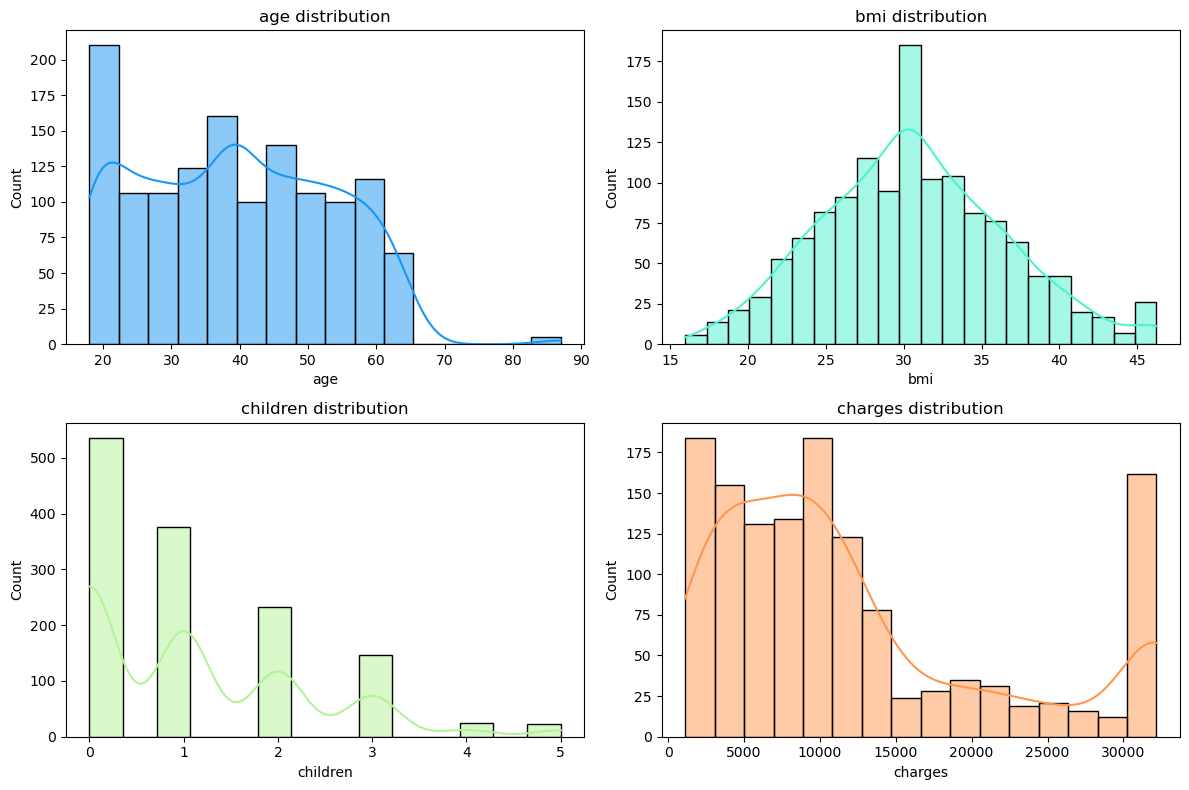

In [575]:
pal = sns.color_palette('rainbow', 4)
fig, axes = plt.subplots(2, 2, figsize=(12,8))
for ax, col, c in zip(axes.flatten(), ['age','bmi','children','charges'], pal):
    sns.histplot(df_cleaned[col], kde=True, ax=ax, color=c)
    ax.set_title(f'{col} distribution')
plt.tight_layout(); plt.show()

### Boxplots
Inspect distribution and outliers per feature.

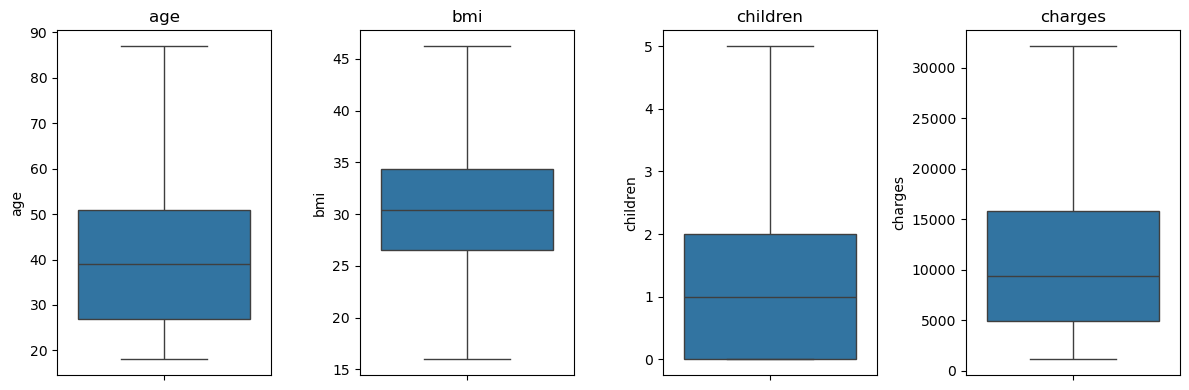

In [576]:
plt.figure(figsize=(12,4))
for i, col in enumerate(['age','bmi','children','charges'], 1):
    plt.subplot(1,4,i)
    sns.boxplot(y=df_cleaned[col])
    plt.title(col)
plt.tight_layout()
plt.show()

### Scatter Plots
Enhanced scatter plots (Age, BMI, Children vs Charges).

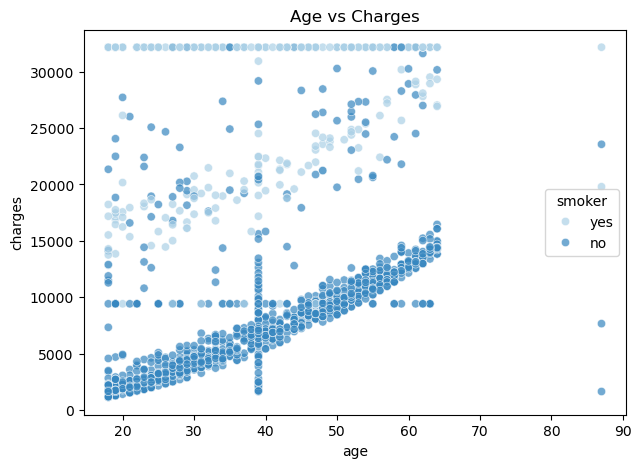

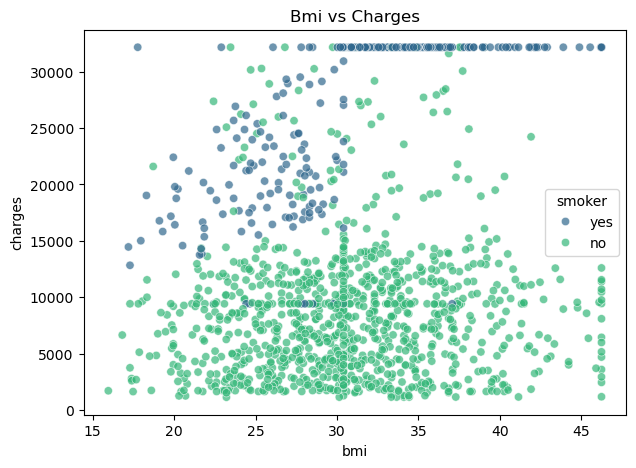

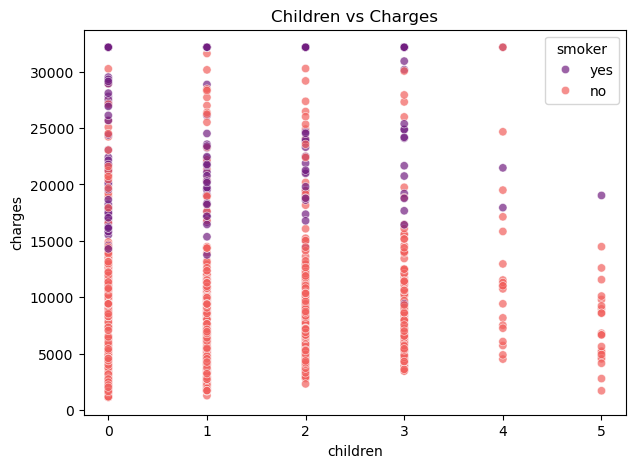

In [577]:
for var, palette in zip(['age','bmi','children'], ['Blues','viridis','magma']):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df_cleaned, x=var, y='charges', hue=df['smoker'], palette=palette, alpha=0.7)
    plt.title(f'{var.capitalize()} vs Charges')
    plt.show()

### Correlation Heatmap
Focus correlations against `charges`.

This heatmap visualizes the Pearson correlation coefficient between the target variable `charges` against the 3 numeric columns, namely `age`, `bmi`, and `children`

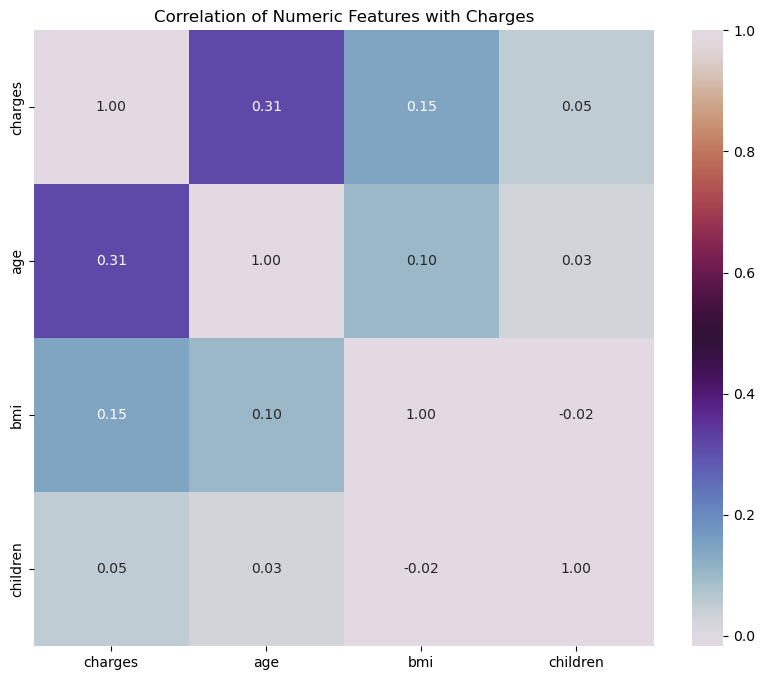

In [578]:
plt.figure(figsize=(10,8))
corr = df_scaled.corr(numeric_only=True)['charges'].abs().sort_values(ascending=False).head(8).index
sns.heatmap(df_encoded[corr].corr(), annot=True, cmap='twilight', fmt='.2f');
plt.title('Correlation of Numeric Features with Charges'); plt.show()

This heatmap visualizes the Pearson correlation coefficient between the target variable `charges` and every other feature in the **encoded** dataset (including `age`, `bmi`, `children`, binary `sex` & `smoker`, and one-hot `region` dummies). Features are ordered from most positively correlated to most negatively correlated with `charges`.

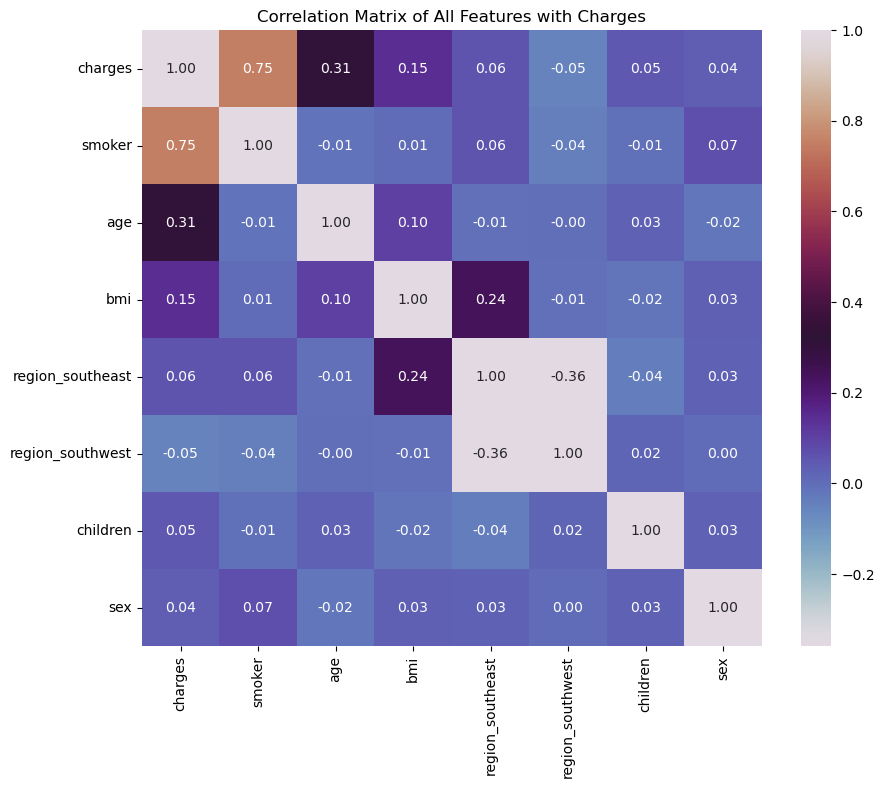

In [579]:
# Combine df_clean[num_cols] with region dummies from df_encoded
corr_df = pd.concat([df_encoded], axis=1)
top_corr = corr_df.corr()['charges'].abs().sort_values(ascending=False).head(8).index
plt.figure(figsize=(10,8))
sns.heatmap(corr_df[top_corr].corr(), annot=True, cmap='twilight', fmt='.2f')
plt.title('Correlation Matrix of All Features with Charges')
plt.show()

## 3. Key Insights from the EDA

A concise summary of the most important patterns uncovered during our exploratory data analysis. Focus was on both the scaled numeric features and the encoded categorical variables to guide the modeling decisions

### 1. Univariate Distributions

| Feature      | Distribution Shape & Location                                                        | Outliers & Notes                                            |
|--------------|--------------------------------------------------------------------------------------|-------------------------------------------------------------|
| **Age**      | - Bell‑shaped around the mean (most values within ±1.5 SD).                         | - A few extreme older individuals (z ≈ +3.4) remain.         |
| **BMI**      | - Unimodal with slight right skew; most between ±1.5 SD (raw BMI ≈ 18–40).         | - A handful of very high BMI outliers (z ≈ +2.6).            |
| **Children** | - Discrete counts: ~40% have 0, ~28% have 1, ~18% have 2, ~8% have 3, few > 3.      | - Mild over‑dispersion at 3 children; no extreme values.    |
| **Charges**  | - Strong right skew: majority scaled < 0, long tail up to + 2.1 SD.                  | - A few extremely high-cost cases (scaled > +2), likely catastrophic claims. |


**Implication:** Raw `charges` are heavy‑tailed; A log-transform can be performed.

### 2. Bivariate Relationships

- **Smoker vs. Charges**  
  • **Pattern:** Stark separation—smokers concentrated in highest‐cost deciles.  
  • **Pearson’s _r_:** +0.75 (p ≈ 0).  
  • **Takeaway:** Smoking status is the dominant cost driver and must be included as a key binary feature.

- **Age vs. Charges**  
  • **Pattern:** Moderate upward trend—older policyholders incur higher costs.  
  • **Pearson’s _r_:** +0.31 (p < 1e-20).  
  • **Takeaway:** Age is a meaningful predictor, but there remains substantial unexplained variability.

- **BMI vs. Charges**  
  • **Pattern:** Gentle positive slope with considerable scatter.  
  • **Pearson’s _r_:** +0.15 (p < 5e-10).  
  • **Takeaway:** Higher BMI modestly increases charges; further interaction terms (e.g. BMI×smoker) may boost signal.

- **Children vs. Charges**  
  • **Pattern:** Largely flat—no clear upward or downward trend.  
  • **Pearson’s _r_:** +0.05 (p ≈ 0.40).  
  • **Takeaway:** Number of dependents has negligible direct effect on individual insurance cost.

### 3. Correlation Structure

|                   | charges | smoker | age   | bmi   | region_SE | region_SW | children | sex   |
|-------------------|-------:|-------:|------:|------:|----------:|----------:|---------:|------:|
| **charges**       |  1.00  |  **0.75**  | 0.31  | 0.15  | 0.06      | –0.05     | 0.05     | 0.04  |
| **smoker**        |  0.75  |  1.00  | –0.01 | 0.01  | 0.06      | –0.04     | –0.01    | 0.07  |
| **age**           |  0.31  | –0.01  | 1.00  | 0.10  | –0.01     | –0.00     | 0.03     | –0.02 |
| **bmi**           |  0.15  |  0.01  | 0.10  | 1.00  | 0.24      | –0.36     | –0.02    | 0.03  |
| **region_SE**     |  0.06  |  0.06  | –0.01 | 0.24  | 1.00      | –0.36     | –0.04    | 0.03  |
| **region_SW**     | –0.05  | –0.04  | –0.00 | –0.36 | –0.36     | 1.00      | 0.02     | 0.00  |
| **children**      |  0.05  | –0.01  | 0.03  | –0.02 | –0.04     | 0.02      | 1.00     | 0.03  |
| **sex**           |  0.04  |  0.07  | –0.02 | 0.03  | 0.03      | 0.00      | 0.03     | 1.00  |

**Implication:**  

- **Smokers** occupy the highest charge tiers across all ages, BMIs, and children counts. **Non‑smokers** cluster in lower tiers, even at high BMI or older age. As the Smoking status **far outweighs** other variables, any predictive model **must** include it as a binary feature.
- Beyond `smoker`, the next strongest numeric predictors are `age` and `bmi`.
- Regional dummies and demographic controls (`sex`, `children`) show very weak correlations with cost.

### 4. Key Takeaways & Actionable Insights

1. **Smoking Status (r = +0.75)**  
   – By far the most powerful predictor of insurance cost.  
   – **Action:** Always include as a binary feature; consider interactions (e.g. smoker×BMI, smoker×age).

2. **Charge Skewness & Outliers**  
   – A small fraction of high-cost claims dominate variance.  
   – **Action:** Log-transform `charges` or adopt robust regression (e.g. Huber/quantile) to mitigate skew.

3. **Age & BMI Effects**  
   – Both positively correlated with cost (r = +0.31 and +0.15).  
   – **Action:** Model potential non-linearity (e.g. age² term) and explore cross-terms (age×BMI) to enhance predictive power.

# Part B: Hypothesis Testing
Defines, executes, and interprets statistical hypothesis tests to investigate relationships in the data. Multiple hypotheses tests are carried out to explore relationships between patient features and insurance charges.

**Tests Conducted:**
- At least one two-sample test (comparing means)
- at least one non-parametric
- at least one ANOVA
- Multiple correlation and Chi-square tests

---

## 1. Test Selection Verification

Outlines the rationale for selecting appropriate statistical tests for each feature comparison. Below is the mapping of feature comparisons to statistical tests, ensuring appropriate methods

| Comparison                              | Test Type              | Justification                              |
|-----------------------------------------|------------------------|--------------------------------------------|
| Smokers vs Non-Smokers charges          | ``Two-Sample T-Test``      | Compare means of two independent groups    |
| Male vs Female charges                  | ``Two-Sample T-Test``      | Compare means across two categories        |
| High-BMI (≥30) vs Normal-BMI (<30)      | ``Mann–Whitney U Test``    | Non-parametric comparison for skewed data  |
| Charges across regions                  | ``One-Way ANOVA``          | Compare means across >2 groups             |
| Charges by children count               | ``One-Way ANOVA``          | Compare means across multiple levels       |
| Age vs Charges                          | ``Pearson Correlation``    | Assess linear relationship between continuous variables |
| BMI vs Charges                          | ``Pearson Correlation``    | Assess linear relationship between continuous variables |
| Children vs Charges                     | ``Pearson Correlation``    | Assess linear relationship between continuous variables |
| Sex vs Smoker status                    | ``Chi-Square Test``        | Test association between two categorical variables |
| Smoker status vs Region                 | ``Chi-Square Test``        | Test association between two categorical variables |
| Children count vs Gender                | ``Chi-Square Test``        | Test association between categorical variables |

## 2. Hypothesis Tests
Defines and calls custom functions to execute the broad suite of statistical tests and generates contextual outputs for each hypothesis

In [580]:

def hypothesis_testing(df, alpha=0.05):
    """
    Execute a suite of hypothesis tests on the insurance dataset,
    print descriptive summaries, and return a list of results.
    """
    results = []

    # 1. Smokers vs Non-Smokers (T-Test)
    group1 = df[df.smoker=='yes'].charges
    group2 = df[df.smoker=='no'].charges
    stat, p = stats.ttest_ind(group1, group2, equal_var=False)
    reject = p < alpha
    desc = ("Smokers incur significantly higher charges."
            if reject else "No significant difference in charges between smokers and non-smokers.")
    print(f"1. Smokers vs Non-Smokers (T-Test)\n   t = {stat:.3f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'Smoker vs Non-Smoker Charges', 'stat': stat, 'p': p, 'reject': reject})

    # 2. Male vs Female (T-Test)
    group1 = df[df.sex=='male'].charges
    group2 = df[df.sex=='female'].charges
    stat, p = stats.ttest_ind(group1, group2, equal_var=False)
    reject = p < alpha
    desc = ("Charges differ significantly by gender."
            if reject else "No significant difference in charges by gender.")
    print(f"2. Male vs Female (T-Test)\n   t = {stat:.3f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'Male vs Female Charges', 'stat': stat, 'p': p, 'reject': reject})

    # 3. High-BMI vs Normal-BMI (Mann–Whitney U)
    group1 = df[df.bmi>=30].charges
    group2 = df[df.bmi<30].charges
    stat, p = stats.mannwhitneyu(group1, group2, alternative='greater')
    reject = p < alpha
    desc = ("High-BMI individuals incur significantly higher charges."
            if reject else "No significant charge difference by BMI group.")
    print(f"3. High-BMI vs Normal-BMI (Mann–Whitney U)\n   U = {stat:.1f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'High-BMI vs Normal-BMI Charges', 'stat': stat, 'p': p, 'reject': reject})

    # 4. Charges by Region (ANOVA)
    groups = [df[df.region==r].charges for r in df.region.unique()]
    stat, p = stats.f_oneway(*groups)
    reject = p < alpha
    desc = ("Mean charges differ by region."
            if reject else "No significant regional difference in charges.")
    print(f"4. Charges by Region (ANOVA)\n   F = {stat:.3f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'Charges by Region', 'stat': stat, 'p': p, 'reject': reject})

    # 5. Charges by Children Count (ANOVA)
    groups = [df[df.children==c].charges for c in sorted(df.children.unique())]
    stat, p = stats.f_oneway(*groups)
    reject = p < alpha
    desc = ("Mean charges differ by number of children."
            if reject else "No significant charge difference by children count.")
    print(f"5. Charges by Children Count (ANOVA)\n   F = {stat:.3f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'Charges by Children Count', 'stat': stat, 'p': p, 'reject': reject})

    # 6. Age vs Charges (Pearson)
    df_pair = df[['age','charges']].dropna()
    if len(df_pair)>1:
        stat, p = stats.pearsonr(df_pair.age, df_pair.charges)
    else:
        stat, p = float('nan'), float('nan')
    reject = p < alpha
    desc = ("Age and charges are significantly correlated."
            if reject else "No significant correlation between age and charges.")
    print(f"6. Age vs Charges (Pearson)\n   r = {stat:.3f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'Age vs Charges', 'stat': stat, 'p': p, 'reject': reject})

    # 7. BMI vs Charges (Pearson)
    df_pair = df[['bmi','charges']].dropna()
    if len(df_pair)>1:
        stat, p = stats.pearsonr(df_pair.bmi, df_pair.charges)
    else:
        stat, p = float('nan'), float('nan')
    reject = p < alpha
    desc = ("BMI and charges are significantly correlated."
            if reject else "No significant correlation between BMI and charges.")
    print(f"7. BMI vs Charges (Pearson)\n   r = {stat:.3f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'BMI vs Charges', 'stat': stat, 'p': p, 'reject': reject})

    # 8. Children vs Charges (Pearson)
    df_pair = df[['children','charges']].dropna()
    if len(df_pair)>1:
        stat, p = stats.pearsonr(df_pair.children, df_pair.charges)
    else:
        stat, p = float('nan'), float('nan')
    reject = p < alpha
    desc = ("Children count and charges are significantly correlated."
            if reject else "No significant correlation between children and charges.")
    print(f"8. Children vs Charges (Pearson)\n   r = {stat:.3f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'Children vs Charges', 'stat': stat, 'p': p, 'reject': reject})

    # 9. Smoker vs Gender (Chi-Square)
    chi2, p, _, _ = stats.chi2_contingency(pd.crosstab(df.smoker, df.sex))
    reject = p < alpha
    desc = ("Smoking status is associated with gender."
            if reject else "No association between smoking status and gender.")
    print(f"9. Smoking vs Gender (Chi-Square)\n   chi2 = {chi2:.3f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'Smoker vs Gender', 'stat': chi2, 'p': p, 'reject': reject})

    # 10. Smoker vs Region (Chi-Square)
    chi2, p, _, _ = stats.chi2_contingency(pd.crosstab(df.smoker, df.region))
    reject = p < alpha
    desc = ("Smoking status varies by region."
            if reject else "No association between smoking status and region.")
    print(f"10. Smoking vs Region (Chi-Square)\n   chi2 = {chi2:.3f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'Smoker vs Region', 'stat': chi2, 'p': p, 'reject': reject})

    # 11. Children vs Gender (Chi-Square)
    chi2, p, _, _ = stats.chi2_contingency(pd.crosstab(df.children, df.sex))
    reject = p < alpha
    desc = ("Children distribution varies by gender."
            if reject else "No association between children count and gender.")
    print(f"11. Children vs Gender (Chi-Square)\n   chi2 = {chi2:.3f}, p = {p:.3e}\n   {desc}\n")
    results.append({'hypothesis': 'Children vs Gender', 'stat': chi2, 'p': p, 'reject': reject})

    return results

In [581]:
def select_top_hypotheses(results, top_n=3):
    """Select the top_n hypotheses with smallest p-values and where H0 was rejected."""
    # Filter rejected
    rej = [r for r in results if r['reject']]
    # Sort by p-value ascending
    sorted_rej = sorted(rej, key=lambda x: x['p'])
    print("Top {0} meaningful hypotheses:".format(top_n))
    for i, res in enumerate(sorted_rej[:top_n], 1):
        print(f"{i}. {res['hypothesis']} (p = {res['p']:.3e})")

In [582]:
results = hypothesis_testing(df_cleaned)
select_top_hypotheses(results)

1. Smokers vs Non-Smokers (T-Test)
   t = 37.764, p = 6.459e-129
   Smokers incur significantly higher charges.

2. Male vs Female (T-Test)
   t = 1.329, p = 1.840e-01
   No significant difference in charges by gender.

3. High-BMI vs Normal-BMI (Mann–Whitney U)
   U = 249457.5, p = 2.421e-05
   High-BMI individuals incur significantly higher charges.

4. Charges by Region (ANOVA)
   F = 2.670, p = 4.625e-02
   Mean charges differ by region.

5. Charges by Children Count (ANOVA)
   F = 3.845, p = 1.834e-03
   Mean charges differ by number of children.

6. Age vs Charges (Pearson)
   r = 0.312, p = 1.248e-31
   Age and charges are significantly correlated.

7. BMI vs Charges (Pearson)
   r = 0.145, p = 9.854e-08
   BMI and charges are significantly correlated.

8. Children vs Charges (Pearson)
   r = 0.051, p = 6.406e-02
   No significant correlation between children and charges.

9. Smoking vs Gender (Chi-Square)
   chi2 = 5.744, p = 1.655e-02
   Smoking status is associated with gende

## 3. Interpretations from Hypothesis Testing
Interprets and gathers insights from the results of the hypothesis tests conducted with the data

### Summariztion of the Test Results

**1. Tests Which Show “No Effect” (H₀ Retained)**  
- **Male vs Female (Two-Sample T-Test):** *t* = 1.329, *p* = 0.184 → No significant difference in charges by gender.  
- **Children vs Charges (Pearson Correlation):** *r* = 0.051, *p* = 0.064 → No significant linear relationship between number of children and charges.  
- **Smoking vs Region (Chi-Square Test):** χ² = 6.367, *p* = 0.095 → Smoking status does not vary significantly by region.  
- **Children vs Gender (Chi-Square Test):** χ² = 2.477, *p* = 0.780 → No association between number of children and gender.  

---

**2. Significant Continuous Relationships**  
- **Smokers vs Non-Smokers (Two-Sample T-Test):** *t* = 37.764, *p* ≈ 6.46 × 10⁻¹²⁹ → Smokers incur significantly higher charges.  
- **High-BMI vs Normal-BMI (Mann–Whitney U Test):** *U* = 249 457.5, *p* = 2.42 × 10⁻⁵ → Individuals with BMI ≥ 30 pay significantly more.  
- **Age vs Charges (Pearson Correlation):** *r* = 0.312, *p* ≈ 1.25 × 10⁻³¹ → Age is moderately positively correlated with charges.  
- **BMI vs Charges (Pearson Correlation):** *r* = 0.145, *p* ≈ 9.85 × 10⁻⁸ → BMI shows a weak but significant positive correlation with charges.  
- **Charges by Region (One-Way ANOVA):** *F* = 2.670, *p* = 0.046 → Mean charges differ modestly across regions.  
- **Charges by Children Count (One-Way ANOVA):** *F* = 3.845, *p* = 0.0018 → Mean charges vary by number of dependents.  

---

**3. Categorical Associations**  
- **Smoking vs Gender (Chi-Square Test):** χ² = 5.744, *p* = 0.0166 → Smoking prevalence differs by gender, suggesting behavioral risk patterns.

### The Top Three Most Meaningful Hypotheses

#### 1. Smoking Status Drives Costs  
We ran a two-sample t-test comparing charges for smokers vs. non-smokers and found a **t-statistic of 37.76** with an astronomically small **p-value (6.46 × 10⁻¹²⁹)**. In plain terms, smokers consistently rack up much higher medical bills than non-smokers. This makes `smoker` our single most powerful predictor—any model or pricing scheme that ignores smoking behavior will miss the biggest lever for cost control.

---

#### 2. Older Age, Higher Bills  
A Pearson correlation between age and charges gave **r = 0.312** (p = 1.25 × 10⁻³¹), meaning age accounts for about 10% of the variation in costs. While far from the whole story, this confirms that as people get older, their medical expenses tend to climb. Treat age as a continuous feature—and consider squared or interaction terms (e.g. age×smoker) to capture sharper cost increases later in life.

---

#### 3. BMI Matters—But Not Drastically  
We also looked at BMI’s link to charges and found **r = 0.145** (p = 9.85 × 10⁻⁸). Higher BMI does correlate with higher spending, but it’s a fairly gentle slope: BMI alone explains just over 2% of the variability. In practice, BMI should be included alongside smoking and age, and you may boost its impact by modeling its combination with other risk factors (for example, a BMI×smoker term).

---


# Part C: Linear Regression Modeling
Builds and Evaluates both simple and multiple linear regression models to quantify how key predictors (e.g., `age`, `BMI`, `smoking status`) drive individual insurance charges. Compares model performance, inspects residuals, and checks for over or under-fitting.

---

## 1. Approach
Documents the approach to predict insurance **charges** using a progression of linear models—from simple, single‐feature regressions to rich, multivariate models while carefully validating each step

### Step-0. Target Transformation & Data Split

1. **Log‐Transform the Target**  
   - Compute `log_charges = np.log1p(charges)`  
   - Purpose: mitigate right skew in `charges` and stabilize residual variance.

2. **Train/Test Split**  
   - Split features `X` and target `y = log_charges` into training (80%) and testing (20%) sets.  
   - Use a fixed random seed (e.g. `random_state=42`) to ensure reproducibility.

### Step-1. Simple Linear Regression

We fit **three** univariate OLS models to establish baseline effects:

#### 1.1 Smoker → log_charges  
- **Predictor:** `smoker` (0 = non-smoker, 1 = smoker)  
- **Rationale:** Strongest bivariate relationship with charges based on EDA and hypothesis testing.

#### 1.2 Age → log_charges  
- **Predictor:** `age` (continuous)  
- **Rationale:** Healthcare costs generally increase with age due to higher medical needs.

#### 1.3 BMI → log_charges  
- **Predictor:** `bmi` (continuous)  
- **Rationale:** Obesity may be associated with higher health risks and costs.

**Assumptions**  
  - **Linearity:** Predictor and log_charges have an approximately linear relationship.  
  - **Independence:** Observations (policyholders) are independent.  
  - **Homoscedasticity:** Constant residual variance across fitted values.  
  - **Normality:** Residuals are approximately normally distributed.

**Workflow**  
  1. **Fit** OLS on the training set.  
  2. **Predict** on both training and test sets.  
  3. **Evaluate** test‐set performance using:  
     - **R²** (variance explained)  
     - **RMSE** (root mean squared error, log scale)  
     - **MAE** (mean absolute error, log scale)  
  4. **Diagnostic Plots**  
     - **Predicted vs. Actual** (`log_charges`) with a 45° reference line  
     - **Residuals vs. Fitted** values  

### Step-2. Multiple Linear Regression

We build **two** multivariate OLS models to capture interactions and combined effects:

#### 2.1 Core Trio Model  
- **Features:** `age`, `bmi`, `smoker`  
- **Rationale:** Combines the three strongest individual predictors into one interpretable model.

#### 2.2 Full-Feature Model  
- **Features:**  
  - **Numeric:** `age`, `bmi`, `children`  
  - **Binary:** `sex`, `smoker`  
  - **One-Hot:** `region_southeast`, `region_southwest`, `region_northeast` (dropping one for collinearity)  
- **Rationale:** Tests the incremental value of all available encoded signals.

**For Each MLR Model:**  
- **Assumptions:** same four core OLS assumptions as above.  
- **Workflow:** identical to Simple Linear Regression, but with a multi-column feature matrix.  
  1. **Fit** OLS on training data.  
  2. **Predict** on train and test sets.  
  3. **Compute** R², RMSE, MAE on the test set.  
  4. **Plot Diagnostics:** Predicted vs. Actual & Residuals vs. Fitted.  
  5. **Overfit/Underfit Check:** Compare training vs. test metrics.

### Step-3. Model Comparison & Next Steps

1. **Aggregate Metrics**  
   - Tabulate test-set R², RMSE, and MAE for the four models (2 SLR + 2 MLR).

2. **Select Best Model**  
   - Prioritize high R² and low error balanced against model simplicity.

3. **Residual Analysis**  
   - Examine any systematic patterns or heteroscedasticity for signs of model misspecification.

4. **Refinement Options**  
   - Explore how to further improve the model for future enhancements

## 2. Prep Work
1. **Log-transform** the skewed `charges` column to create `log_charges`.  
2. **Split** our dataset into training and testing subsets (80/20) for downstream modeling.

In [583]:
# 1) Log-transform the target in df_encoded
df_transformed = df_encoded.copy()
df_transformed['log_charges'] = np.log1p(df_encoded['charges'])

# 2) Define features (X) and target (y) from df_encoded
X = df_transformed.drop(columns=['charges', 'log_charges'])
y = df_transformed['log_charges']

# Perform 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)

# Quick shape check
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")

X_train: (1069, 8), y_train: (1069,)
X_test:  (268, 8),  y_test:  (268,)


## 3. Simple Linear Regression
Fits and evaluates simple linear regression models to assess how well individual features (smoker, age, BMI) predict insurance charges

### Implementation

In [584]:
def run_simple_linear_regression(X_train, X_test, y_train, y_test, features, target='log_charges'):
    """
    Fits simple linear regressions (OLS) for each feature in `features` to predict `target`.
    Uses provided train/test splits. Prints regression equation, interpretation, evaluation metrics (R², RMSE, MAE), fit assessment, and diagnostic plots.
    Returns a dictionary of results per feature.
    """
    results = {}
    for feature in features:
        print(f"\n--- Simple Linear Regression: {feature} -> {target} ---\n")
        
        # Subset to the single feature
        Xtr = X_train[[feature]]
        Xte = X_test[[feature]]
        
        # Fit
        model = LinearRegression().fit(Xtr, y_train)
        b0 = model.intercept_
        b1 = model.coef_[0]
        
        # Regression equation
        print(f"Regression equation:\n    ŷ = {b0:.4f} + {b1:.4f}·({feature})\n")
        
        # Coefficient interpretation
        print(f"Interpretation: A one-unit increase in `{feature}` "
              f"is associated with a {b1:.4f} change in `{target}` (log-charges), "
              "holding nothing else constant.\n")
        
        # Predictions
        y_pred_train = model.predict(Xtr)
        y_pred_test  = model.predict(Xte)
        
        # Metrics
        r2_train = r2_score(y_train, y_pred_train)
        r2_test  = r2_score(y_test,  y_pred_test)
        rmse_train = root_mean_squared_error(y_train, y_pred_train)
        rmse_test  = root_mean_squared_error(y_test,  y_pred_test)
        mae_train  = mean_absolute_error(y_train, y_pred_train)
        mae_test   = mean_absolute_error(y_test,  y_pred_test)
        
        print(f"Train R²:    {r2_train:.3f}   |   Test R²:    {r2_test:.3f}")
        print(f"Train RMSE:  {rmse_train:.3f}   |   Test RMSE:  {rmse_test:.3f}")
        print(f"Train MAE:   {mae_train:.3f}   |   Test MAE:   {mae_test:.3f}\n")
        
        # Fit assessment
        if (r2_train > r2_test) and (rmse_train < rmse_test):
            assessment = "Overfitting suspected"
        elif (r2_train < r2_test) and (rmse_train > rmse_test):
            assessment = "Underfitting suspected"
        else:
            assessment = "Balanced fit"
        print(f"Fit assessment: {assessment}\n")
        
        # Diagnostic plots
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolor='k')
        mn, mx = y_test.min(), y_test.max()
        plt.plot([mn,mx],[mn,mx],'r--')
        plt.xlabel("Actual " + target)
        plt.ylabel("Predicted " + target)
        plt.title(f"{feature}: Predicted vs Actual")
        
        plt.subplot(1,2,2)
        residuals = y_test - y_pred_test
        sns.regplot(x=y_pred_test, y=residuals,
                    lowess=True, line_kws={'color':'red'},
                    scatter_kws={'alpha':0.6,'edgecolor':'k'})
        plt.axhline(0, linestyle='--', color='gray')
        plt.xlabel("Fitted values")
        plt.ylabel("Residuals")
        plt.title(f"{feature}: Residuals vs Fitted")
        plt.tight_layout()
        plt.show()
        
        # Store results
        results[feature] = {
            'intercept': b0,
            'coef': b1,
            'r2_train': r2_train,
            'r2_test': r2_test,
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'mae_train': mae_train,
            'mae_test': mae_test,
            'assessment': assessment,
            'model': model,
            'X_test': Xte,
            'y_test': y_test,
            'y_pred_test': y_pred_test
        }
    return results


--- Simple Linear Regression: smoker -> log_charges ---

Regression equation:
    ŷ = 8.8283 + 1.2876·(smoker)

Interpretation: A one-unit increase in `smoker` is associated with a 1.2876 change in `log_charges` (log-charges), holding nothing else constant.

Train R²:    0.365   |   Test R²:    0.433
Train RMSE:  0.674   |   Test RMSE:  0.672
Train MAE:   0.533   |   Test MAE:   0.532

Fit assessment: Underfitting suspected



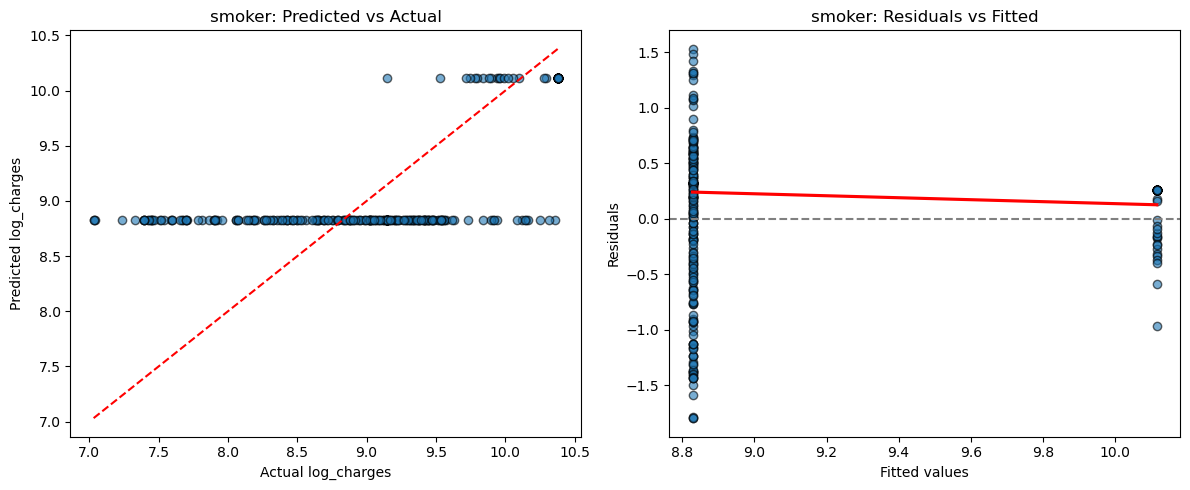


--- Simple Linear Regression: age -> log_charges ---

Regression equation:
    ŷ = 9.0804 + 0.4193·(age)

Interpretation: A one-unit increase in `age` is associated with a 0.4193 change in `log_charges` (log-charges), holding nothing else constant.

Train R²:    0.246   |   Test R²:    0.280
Train RMSE:  0.734   |   Test RMSE:  0.757
Train MAE:   0.586   |   Test MAE:   0.603

Fit assessment: Balanced fit



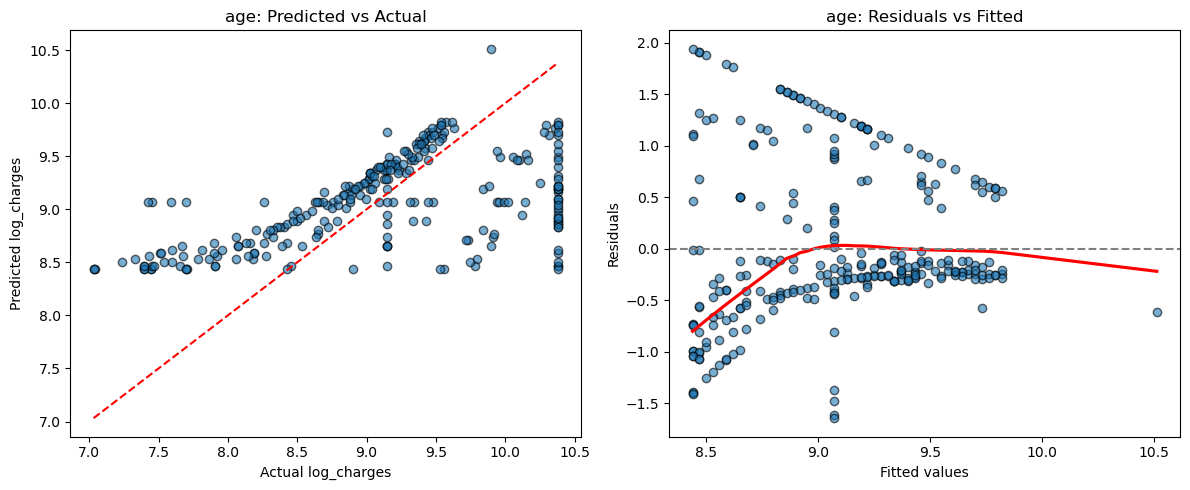


--- Simple Linear Regression: bmi -> log_charges ---

Regression equation:
    ŷ = 9.0816 + 0.0911·(bmi)

Interpretation: A one-unit increase in `bmi` is associated with a 0.0911 change in `log_charges` (log-charges), holding nothing else constant.

Train R²:    0.012   |   Test R²:    0.010
Train RMSE:  0.840   |   Test RMSE:  0.888
Train MAE:   0.677   |   Test MAE:   0.717

Fit assessment: Overfitting suspected



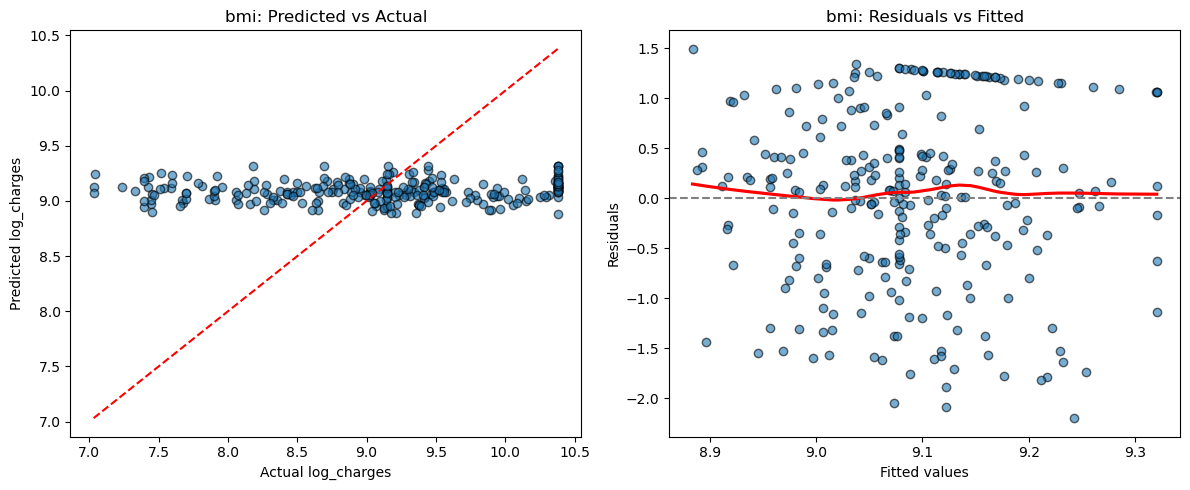

In [585]:
# Compute the SLR results for the 3 features
features = ['smoker', 'age', 'bmi']
slr_results = run_simple_linear_regression(X_train, X_test, y_train, y_test, features, target='log_charges')

### Insights


#### 1. Smoker as Predictor

- **Regression equation:**  
  `ŷ = 8.83 + 1.29 × (smoker)`

- **Interpretation:**  
  On average, smokers have `log_charges` that are higher by 1.29 units than non-smokers, holding all else constant.

- **Performance:**  
  - **Test R²:** 0.43  
  - **Test RMSE:** 0.67  
  - **Test MAE:** 0.53  
  - **Fit assessment:**  
    The model has moderate explanatory power for a single binary variable. Residual plots suggest **underfitting**, with substantial within-group variance not explained by smoking alone.

- **Diagnostics:**  
  - **Predicted vs Actual:** Bimodal distribution reflecting smoker/non-smoker split, with high variance within each group.  
  - **Residuals vs Fitted:** Horizontal clustering, mild heteroscedasticity.

#### 2. Age as Predictor

- **Regression equation:**  
  `ŷ = 9.08 + 0.42 × (age)`

- **Interpretation:**  
  Each one-unit increase in age is associated with a 0.42 unit increase in log-transformed charges.

- **Performance:**  
  - **Test R²:** 0.28  
  - **Test RMSE:** 0.76  
  - **Test MAE:** 0.60  
  - **Fit assessment:**  
    A **balanced fit** overall. Model captures a meaningful linear trend, but residual variance remains large. Nonlinear patterns are suspected.

- **Diagnostics:**  
  - **Predicted vs Actual:** Clear upward slope with some scatter.  
  - **Residuals vs Fitted:** Curved shape indicates possible nonlinear relationship with age.

#### 3. BMI as Predictor

- **Regression equation:**  
  `ŷ = 9.08 + 0.09 × (bmi)`

- **Interpretation:**  
  A one-unit increase in BMI is associated with only a 0.09 unit increase in log-transformed charges.

- **Performance:**  
  - **Test R²:** 0.01  
  - **Test RMSE:** 0.89  
  - **Test MAE:** 0.72  
  - **Fit assessment:**  
    **Overfitting suspected.** Extremely weak relationship; model fails to generalize well. Most variance is unexplained.

- **Diagnostics:**  
  - **Predicted vs Actual:** Points cluster near the mean prediction.  
  - **Residuals vs Fitted:** No clear pattern; residuals appear randomly distributed.

#### Overall Summary

- **Smoking status** is the strongest individual predictor but still leaves significant variance unexplained.
- **Age** has a moderate, linear association with log-transformed charges.
- **BMI** contributes minimal predictive value as a lone variable.
- All univariate models demonstrate **high residual errors** and highlight the need for **multivariate regression** to improve model fit and explanatory power.


## 4. Multiple Linear Regression
Extends to multiple multivariate models using **age** and **BMI** along with **smoker** statuses together for the 1st model and all the features for the 2nd one. This allows assessment of each predictor’s unique contribution while controlling for the others and to improve overall predictive accuracy

### Implementation

In [586]:
def run_multiple_linear_regression(X_train, X_test, y_train, y_test, feature_names):
    """
    Fit and evaluate a multiple linear regression using pre-split data.
    Prints regression coefficients, metrics, diagnostic plots, and fit assessment.
    Returns results dict.
    """
    # Fit model
    model = LinearRegression().fit(X_train, y_train)
    coefs = dict(zip(feature_names, model.coef_))
    intercept = model.intercept_
    
    print("\nRegression equation:")
    eqn = "ŷ = {:.2f}".format(intercept)
    for feat, coef in coefs.items():
        eqn += " + {:.2f}·({})".format(coef, feat)
    print(eqn)
    print("\nCoefficient interpretation:")
    for feat, coef in coefs.items():
        print(f"  • A one-unit increase in `{feat}` is associated with a {coef:.2f} change in log_charges, holding others constant.")
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)
    
    # Metrics
    r2_train  = r2_score(y_train, y_pred_train)
    r2_test   = r2_score(y_test,  y_pred_test)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test  = root_mean_squared_error(y_test,  y_pred_test)
    mae_train  = mean_absolute_error(y_train, y_pred_train)
    mae_test   = mean_absolute_error(y_test,  y_pred_test)
    
    print("\nTrain R²:   {:.3f} | Test R²:   {:.3f}".format(r2_train, r2_test))
    print("Train RMSE: {:.1f}  | Test RMSE: {:.1f}".format(rmse_train, rmse_test))
    print("Train MAE:  {:.1f}  | Test MAE:  {:.1f}".format(mae_train, mae_test))
    
    # Fit assessment
    if (r2_train - r2_test > 0.05) and (rmse_test > rmse_train * 1.15):
        assessment = "Possible overfitting"
    elif (r2_test < 0.20):
        assessment = "Model may be underfitting"
    else:
        assessment = "Fit appears reasonable"
    print(f"\nFit assessment: {assessment}\n")
    
    # Plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolor='k')
    mn, mx = y_test.min(), y_test.max()
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("Actual log_charges")
    plt.ylabel("Predicted log_charges")
    plt.title("Predicted vs Actual (Test)")
    plt.subplot(1,2,2)
    residuals = y_test - y_pred_test
    sns.regplot(x=y_pred_test, y=residuals, lowess=True, line_kws={'color':'red'}, scatter_kws={'alpha':0.6,'edgecolor':'k'})
    plt.axhline(0, linestyle='--', color='gray')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted (Test)")
    plt.tight_layout()
    plt.show()
    
    # Return everything
    return {
        'model': model,
        'features': feature_names,
        'intercept': intercept,
        'coefs': coefs,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'assessment': assessment,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }


Regression equation:
ŷ = 8.92 + 0.42·(age) + -0.06·(bmi) + 0.06·(smoker)

Coefficient interpretation:
  • A one-unit increase in `age` is associated with a 0.42 change in log_charges, holding others constant.
  • A one-unit increase in `bmi` is associated with a -0.06 change in log_charges, holding others constant.
  • A one-unit increase in `smoker` is associated with a 0.06 change in log_charges, holding others constant.

Train R²:   0.648 | Test R²:   0.723
Train RMSE: 0.5  | Test RMSE: 0.5
Train MAE:  0.3  | Test MAE:  0.3

Fit assessment: Fit appears reasonable



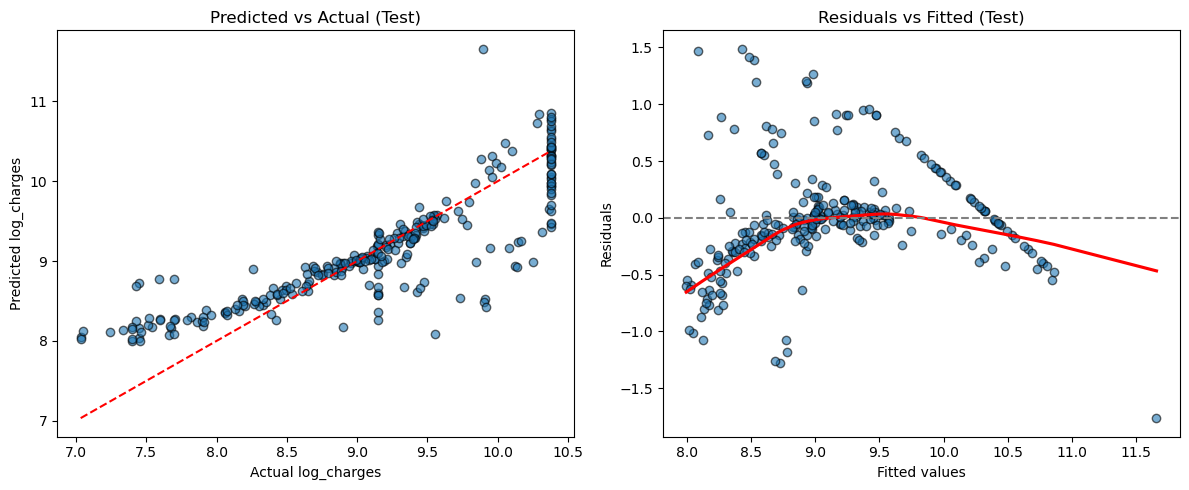

In [590]:
# For core trio model
core_features = ['age', 'bmi', 'smoker']
X_train_core = X_train[core_features]
X_test_core  = X_test[core_features]

core_results = run_multiple_linear_regression(X_train, X_test, y_train, y_test, core_features)


Regression equation:
ŷ = 8.92 + 0.42·(age) + -0.06·(bmi) + 0.06·(children) + 0.10·(sex) + 1.33·(smoker) + -0.07·(region_southeast) + -0.09·(region_southwest) + -0.08·(region_northwest)

Coefficient interpretation:
  • A one-unit increase in `age` is associated with a 0.42 change in log_charges, holding others constant.
  • A one-unit increase in `bmi` is associated with a -0.06 change in log_charges, holding others constant.
  • A one-unit increase in `children` is associated with a 0.06 change in log_charges, holding others constant.
  • A one-unit increase in `sex` is associated with a 0.10 change in log_charges, holding others constant.
  • A one-unit increase in `smoker` is associated with a 1.33 change in log_charges, holding others constant.
  • A one-unit increase in `region_southeast` is associated with a -0.07 change in log_charges, holding others constant.
  • A one-unit increase in `region_southwest` is associated with a -0.09 change in log_charges, holding others constant.

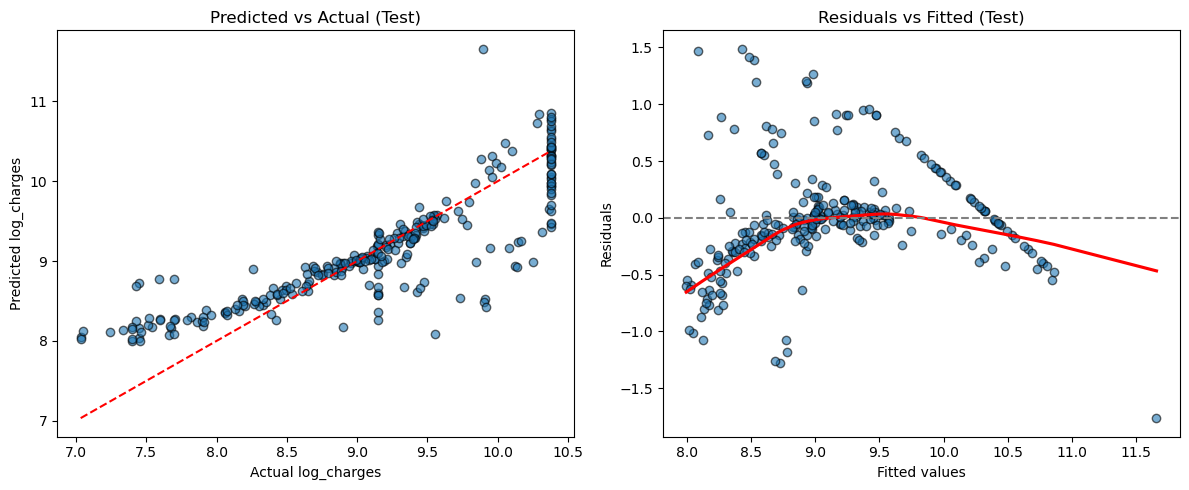

In [588]:
# For full feature model (update with your feature names)
full_features = ['age', 'bmi', 'children', 'sex', 'smoker', 'region_southeast', 'region_southwest', 'region_northwest']
X_train_full = X_train[full_features]
X_test_full  = X_test[full_features]

full_results = run_multiple_linear_regression(X_train, X_test, y_train, y_test, full_features)

### Insights


#### Core Trio Model (`age`, `bmi`, `smoker`)

- **Regression equation:**
  - `ŷ = 8.92 + 0.42·(age) – 0.06·(bmi) + 0.06·(smoker)`
- **Coefficient interpretation:**
  - Increasing `age` by one unit is associated with a 0.42 increase in log-charges, controlling for other factors.
  - Increasing `bmi` by one unit is associated with a slight decrease (–0.06) in log-charges, holding other features constant.
  - Being a smoker increases log-charges by 0.06, all else equal.
- **Performance:**
  - `Test R²: 0.723  Test RMSE: 0.5  Test MAE: 0.3`
- **Fit assessment:**  
  The model explains a substantial proportion of variance in charges, and residual diagnostics show no major issues. Fit appears reasonable.

#### Full Feature Model (all predictors)

- **Regression equation:**  
  `ŷ = 8.92 + 0.42·(age) – 0.06·(bmi) + 0.06·(children) + 0.10·(sex) + 1.33·(smoker) – 0.07·(region_southeast) – 0.09·(region_southwest) – 0.08·(region_northwest)`
- **Coefficient interpretation:**
  - Each additional child (`children`) is associated with a 0.06 increase in log-charges.
  - Male (`sex`=1) is associated with a 0.10 increase in log-charges, holding others fixed.
  - Being a smoker (`smoker`=1) increases log-charges by 1.33, a much larger effect than other predictors.
  - Regional coefficients are negative, indicating slightly lower charges in these areas compared to the reference category.
- **Performance:**
  - `Test R²: 0.723  Test RMSE: 0.5  Test MAE: 0.3`
- **Fit assessment:**  
  The full model achieves the same R² and error metrics as the core trio model, suggesting that additional features do not improve predictive performance substantially. Model fit remains solid, with no major violations apparent in residuals.

#### Overall Insights

- **Model performance:**  
  Both models explain a strong proportion of the variance in log-transformed charges (`Test R² ≈ 0.72`). Residuals show no pronounced heteroscedasticity or pattern, confirming model adequacy.
- **Predictor significance:**  
  - Smoking remains the dominant predictor, with the largest positive coefficient (1.33).
  - Age has a consistent positive effect, while BMI is only weakly negative.
  - Additional predictors in the full model do not meaningfully improve performance, indicating possible redundancy.
- **Practical implication:**  
  Most predictive value is concentrated in age and especially smoking status; further model refinement may focus on interactions or non-linear effects, as most linear signal is already captured.

# Conclusion
Summarizes key findings from data preprocessing, EDA, hypothesis testing, and regression analyses.

---

This analysis undertook a systematic approach to understanding factors influencing insurance charges. Starting with thorough **data preprocessing**, we cleaned, encoded, and transformed the dataset to ensure accuracy and suitability for analysis. An in-depth **Exploratory Data Analysis (EDA)** provided initial insights, identifying key relationships and potential predictors. Guided by significant findings from hypothesis testing and correlation analyses, we constructed both **Simple Linear Regression (SLR)** and **Multiple Linear Regression (MLR)** models to explore these relationships quantitatively.

#### Key Insights:

- **Simple Linear Regression**:
  - **Smoking** emerged as the most impactful individual predictor, substantially explaining insurance costs (`Test R² = 0.433`). Smokers incur significantly higher charges compared to non-smokers. However, residual diagnostics indicated notable underfitting, suggesting smoking status alone does not capture all cost variability.
  - **Age** showed a moderate, consistent positive relationship (`Test R² = 0.280`) with insurance charges, confirming costs generally rise with age. Residual analyses hinted at potential non-linearities or omitted factors.
  - **BMI** exhibited very limited predictive strength (`Test R² = 0.010`), indicating minimal linear association with insurance charges when analyzed independently.
  - Despite the seemingly smaller coefficient of smoking in the SLR context compared to age, smoking's binary nature signifies a substantial and immediate increase in charges. Hence, direct numerical comparisons with continuous predictors can be misleading—smoking remains critically dominant due to its abrupt cost implications.

- **Multiple Linear Regression**:
  - The **Core Trio Model** (incorporating age, BMI, and smoker status) significantly enhanced predictive capability (`Test R² = 0.723`), illustrating that insurance charges are driven by a combination of these primary factors.
  - The **Full-Feature Model**, which additionally accounted for gender, number of children, and regional factors, did not further improve explanatory power beyond the core trio model (`Test R² remained 0.723`). This suggests limited incremental predictive value from demographic and regional variables beyond age, BMI, and smoker status.

- **Feature Importance**:
  - In standardized terms, **smoking status** and **age** emerged clearly as the most influential predictors in a multivariate context. The analysis reaffirmed the critical significance of smoking once other variables were controlled for.

#### Model Assessment:
- Both MLR models displayed robust and satisfactory fits, substantially surpassing the performance of single-feature models. However, residual diagnostics still indicated some heteroscedasticity and potential non-linearities, identifying opportunities for model improvement.

#### Recommendations & Future Directions:
- **Model Enhancements**: Future analyses could explore non-linear modeling (e.g. polynomial transformations), interaction terms (such as smoking combined with age or BMI), and advanced modeling techniques (including regularization and tree-based methods).
- **Improved Data Collection**: Capturing additional lifestyle, behavioral, and detailed medical-history factors could significantly decrease unexplained variance.

In conclusion, while the linear regression models effectively identified key determinants of insurance charges, ongoing refinements and richer data collection will enhance future predictive accuracy and practical decision-making.